# ASTR4004 Assignment 4: Neural Networks
## Submission by Taaseen Islam

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, Model


# Description of the problem

I have a data-cube for the barred-spiral galaxy NGC1365 from the TYPHOON survey (I haven't uploaded it because it's 1.6GB, but I can supply it if necessary). This is a dataset of size $3000 \times 666\times 214$ where there are $3000$ wavelength pixels and the 2d image has $666 \times 214$ spaxels. A lot of these spaxels have no data because there is fundamentally not enough emission there--TYPHOON is a survey that benefits from a very large field of view that often captures regions with little to no emission. 

The galaxy has a central outflow, a bar, spiral arms, and other key features. Usually these features are determined with a mix of investigating the visual morphology and smartly using different emission/absorption lines, but I'm going to try naively applying an ANN to separate the features. For each spaxel, I want to be able to take its spectrum and determine if it fits into one of the following five categories:
- Central/outflow regions
- Spiral arms
- Central bar
- Diffuse exterior regions
- Bad data regions

Given an input spectrum, the ANN should return probabilities that the spectrum fits into one of the five categories as above. 

In [2]:
cube = "data\\N1365_lowres_cal_WCS.fits"

with fits.open(cube) as cube_file:
    #cube_file.info()
    cube_data   = cube_file[0].data
    cube_header = cube_file[0].header

In [3]:
wave_axis = [cube_header["CRVAL3"] + cube_header["CDELT3"]*i for i in range(cube_header["NAXIS3"])]
cut_data = cube_data[:, 270:420, 20:160]
display(dict(cube_header))

{'SIMPLE': True,
 'BITPIX': -32,
 'NAXIS': 3,
 'NAXIS1': 214,
 'NAXIS2': 666,
 'NAXIS3': 3000,
 'DATE': '2016-09-04',
 'COMMENT': FITS (Flexible Image Transport System) format is defined in 'Astronomy
 and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H,
 'CD1_1': -0.000458333333333,
 'CD2_2': 0.000458333333333,
 'CRPIX3': 1,
 'CRVAL3': 3650.0,
 'CD3_3': 1.5,
 'CDELT3': 1.5,
 'CTYPE1': 'RA---TAN',
 'CTYPE2': 'DEC--TAN',
 'EQUINOX': 2000.0,
 'CD2_1': 0.0,
 'CD1_2': 0.0,
 'CRPIX1': 107.5,
 'CRPIX2': 333.5,
 'CRVAL1': 53.3916833333,
 'CRVAL2': -36.1439697222,
 'LONPOLE': 180.0,
 'LATPOLE': 90.0,
 'PV2_1': 0.0,
 'PV2_2': 0.0,
 'HISTORY': PUTAST: Jan 31 12:16:00 2022 World Coordinate System parameters written,
 '': }

In [4]:
sum_all_data = np.sum(cube_data, axis=0)
sum_data = np.sum(cut_data, axis=0)

This is a plot of the entire dataset, summing over the wavelength for the purpose of illustration. 

C:\Users\taase\AppData\Local\Temp\ipykernel_26932\1388898542.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(sum_all_data), origin='lower', vmin=-14, vmax=-11)
C:\Users\taase\AppData\Local\Temp\ipykernel_26932\1388898542.py:2: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(sum_all_data), origin='lower', vmin=-14, vmax=-11)


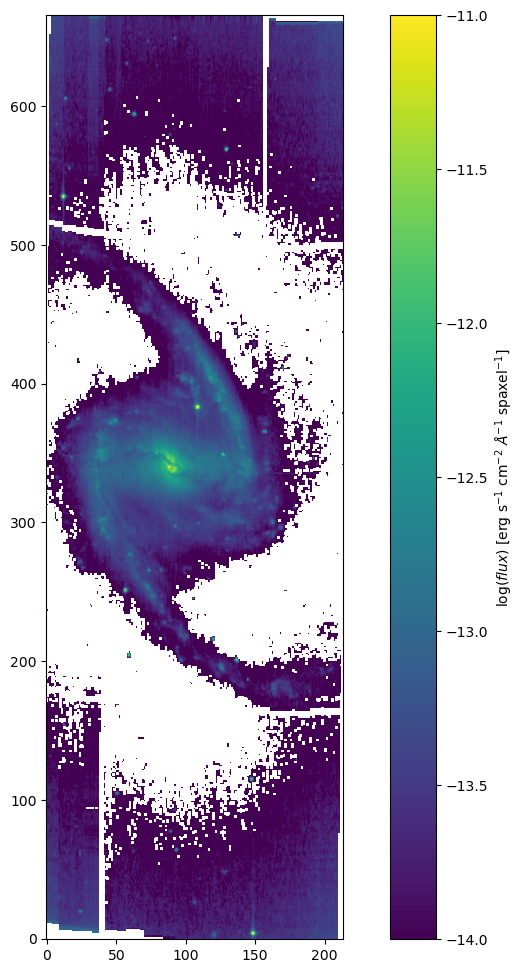

In [5]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(np.log10(sum_all_data), origin='lower', vmin=-14, vmax=-11)
plt.colorbar(label="$\log(flux)$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$ spaxel$^{-1}$]")
plt.show()

Here's a plot of the region data down to show only the galaxy.

C:\Users\taase\AppData\Local\Temp\ipykernel_26932\2169583293.py:3: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(sum_data), origin='lower', vmin=-14, vmax=-11)


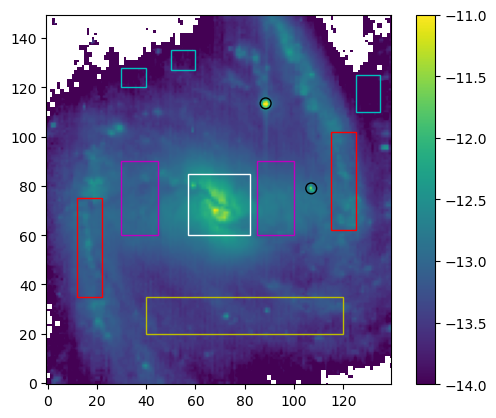

In [6]:
fig,ax = plt.subplots()

im = ax.imshow(np.log10(sum_data), origin='lower', vmin=-14, vmax=-11)

## Center
rect = patches.Rectangle((57, 60), 25, 25,
                           linewidth=1, edgecolor='w', facecolor='None')
ax.add_patch(rect)


## Spiral arms
rect = patches.Rectangle((115, 30 + 32), 10, 40,
                           linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

rect = patches.Rectangle((12, 35), 10, 40,
                           linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)


## Bar
rect = patches.Rectangle((30, 60), 15, 30,
                           linewidth=1, edgecolor='m', facecolor='none')
ax.add_patch(rect)

rect = patches.Rectangle((85, 60), 15, 30,
                           linewidth=1, edgecolor='m', facecolor='none')
ax.add_patch(rect)


## Diffuse gas
rect = patches.Rectangle((40, 20), 80, 15,
                           linewidth=1, edgecolor='y', facecolor='none')
ax.add_patch(rect)


## Bad data
rect = patches.Rectangle((125, 110), 10, 15,
                           linewidth=1, edgecolor='c', facecolor='none')
ax.add_patch(rect)

rect = patches.Rectangle((30, 120), 10, 8,
                           linewidth=1, edgecolor='c', facecolor='none')
ax.add_patch(rect)

rect = patches.Rectangle((50, 127), 10, 8,
                           linewidth=1, edgecolor='c', facecolor='none')
ax.add_patch(rect)

## Stars (unmodelled)
circle = patches.Circle((88.5, 30 + 83.5), radius=2.2, facecolor='none', edgecolor='black')
ax.add_patch(circle)

circle = patches.Circle((107, 30 +  49), radius=2.2, facecolor='none', edgecolor='black')
ax.add_patch(circle)

plt.colorbar(im, ax=ax)

plt.show()

The above plot illustrates the five regions we're looking at:
- **White**: Central
- **Red**: Spiral arms
- **Magenta**: Bar
- **Yellow**: Diffuse gas
- **Cyan**: Bad/low data

The black circles show two individual stars which would have a very different spectrum to the gas, but stars aren't model since there aren't enough spaxels to accurately train an ANN with. The rectangles shown above are used to generate the training set.

In [7]:
center = cut_data[:, 60:85, 57:82]
arms_r = cut_data[:, 62:102, 115:125]
arms_l = cut_data[:, 35:75, 12:22]
bar_l  = cut_data[:, 60:90, 30:45]
bar_r  = cut_data[:, 60:90, 85:100]
diffuse = cut_data[:, 20:35, 40:120]
bad_1 = cut_data[:, 110:125, 125:135]
bad_2 = cut_data[:, 120:128, 30:40]
bad_3 = cut_data[:, 127:135, 50:60]


center = center.reshape(center.shape[0], center.shape[1]*center.shape[2])
arms_r = arms_r.reshape(arms_r.shape[0], arms_r.shape[1]*arms_r.shape[2])
arms_l = arms_l.reshape(arms_l.shape[0], arms_l.shape[1]*arms_l.shape[2])
bar_l = bar_l.reshape(bar_l.shape[0], bar_l.shape[1]*bar_l.shape[2])
bar_r = bar_r.reshape(bar_r.shape[0], bar_r.shape[1]*bar_r.shape[2])
diffuse = diffuse.reshape(diffuse.shape[0], diffuse.shape[1]*diffuse.shape[2])
bad_1 = bad_1.reshape(bad_1.shape[0], bad_1.shape[1]*bad_1.shape[2])
bad_2 = bad_2.reshape(bad_2.shape[0], bad_2.shape[1]*bad_2.shape[2])
bad_3 = bad_3.reshape(bad_3.shape[0], bad_3.shape[1]*bad_3.shape[2])

sections = [center, arms_r, arms_l, bar_l, bar_r, diffuse, bad_1, bad_2, bad_3]

In [8]:
combined = np.concatenate(sections, axis=1)

### Labels:
- Center: **0**
- Arms: **1**
- Bar: **2**
- Diffuse: **3**
- Bad data: **4**

In [9]:
labels = [0]*center.shape[1] + [1]*(arms_r.shape[1] + arms_l.shape[1]) + [2]*(bar_l.shape[1] + bar_r.shape[1]) + [3]*diffuse.shape[1] + [4]*(bad_1.shape[1] + bad_2.shape[1] + bad_3.shape[1])
labels = np.array(labels)

I'm going to transform the data to behave a little better. First, I'm going to cut off the first 500 wavelength bins in each spectrum (from 3350-4400 $\AA$ ) since there is a lot of noise in those points. Second, I'm going to take the average of every 10 wavelength bins and reduce from 2500 bins to 250 bins to reduce noise in the spectrum. 

In [10]:
combined_cut = combined[500:, :]
reshaped = combined_cut.reshape(250, 10, combined.shape[1])
averaged_array = reshaped.mean(axis=1)

Now I prepare $x$ and $y$ for the ANN, transforming them into the shapes that works with tensorFlow

In [11]:
y = np.array(labels[:, None] == np.arange(5), dtype=np.float32)
x = averaged_array.T
print(x.shape)
print(y.shape)

(3835, 250)
(3835, 5)


I'm transforming the x data to always be within $[0,1]$

In [12]:
x = (x-np.min(x))/(np.max(x) - np.min(x))

I shuffle the data randomly to remove bias between the training and testing data

In [13]:
# Set a seed for reproducibility
np.random.seed(123456)
shuffle_index = np.random.permutation(len(labels))
x = x[shuffle_index]
y = y[shuffle_index]
labels = labels[shuffle_index]

Split the training and testing data into a 90/10 split. TensorFlow will further reduce the training set such that we have 70/20/10 for training/validation/testing.

In [14]:
train_size = int(0.9 * len(x))
test_size = len(x) - train_size

x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
labels_test =labels[train_size:]

print(f"Training data has {train_size} elements, and testing has {test_size}")

Training data has 3451 elements, and testing has 384


# Network diagram:
I use Einstein summation in this diagram.
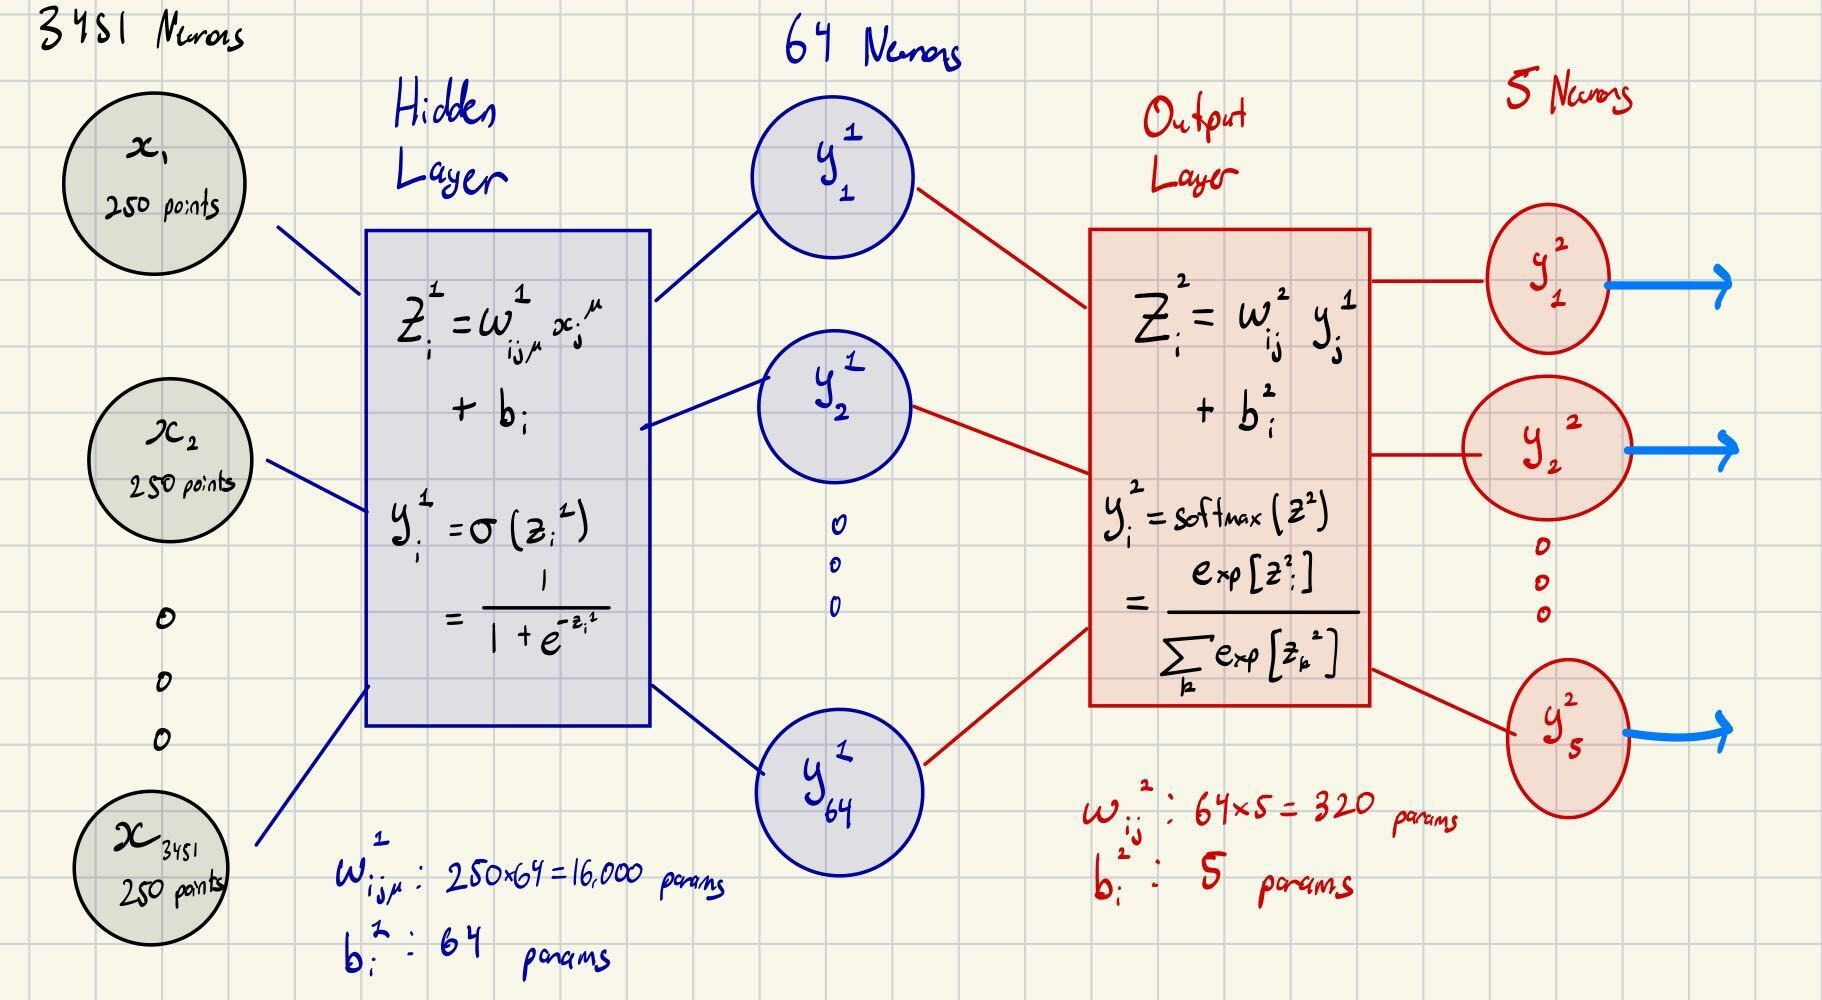

I use a cross-entropy loss function because we are looking for a probability of being in each component. I also use the Adam optimiser to improve training.

In [15]:
model = models.Sequential([
    layers.Input(shape=(250,)),                    # Input layer
    layers.Dense(64, activation='sigmoid'),        # Hidden layer
    layers.Dense(5, activation='softmax')          # Output layer
])

In [16]:
display(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        16,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,389 (64.02 KB)

 Trainable params: 16,389 (64.02 KB)

 Non-trainable params: 0 (0.00 B)

None

I will use tensorial notation with Einstein summation to describe the network, where superscripts are **not** powers. Our network looks like:
$$x_{i\mu} \rightarrow z_i^1 = w^1_{ij\mu}x^{j\mu} + b_i^1 \rightarrow y_i^1 = \sigma(z_i^1)$$
$$y_{i}^1 \rightarrow z_i^2 = w^2_{ij}y^{1j} + b_i^2 \rightarrow y_i^2 = \frac{\exp(z_i^2)}{\sum_{k=1}^{5} \exp(z_k^2)}$$
$$ L= -\sum_{i=1}^5 y_i^2\log(\hat{y_i})$$

In our input layer, $x_{i\mu}$ represents our 3451 spectra each with 250 points ($i$ goes up to 3451, $\mu$ goes up to 250).

In the hidden layer, $i$ goes up to 64 and $j$ goes up to 3451 from the previous layer.

In the output layer, $i$ goes up to 5 and $j$ goes up to 64 from the previous layer.

The gradient equations are shown below. Einstein summation notation applies. $\delta_{ij}$ is the Kronecker delta.

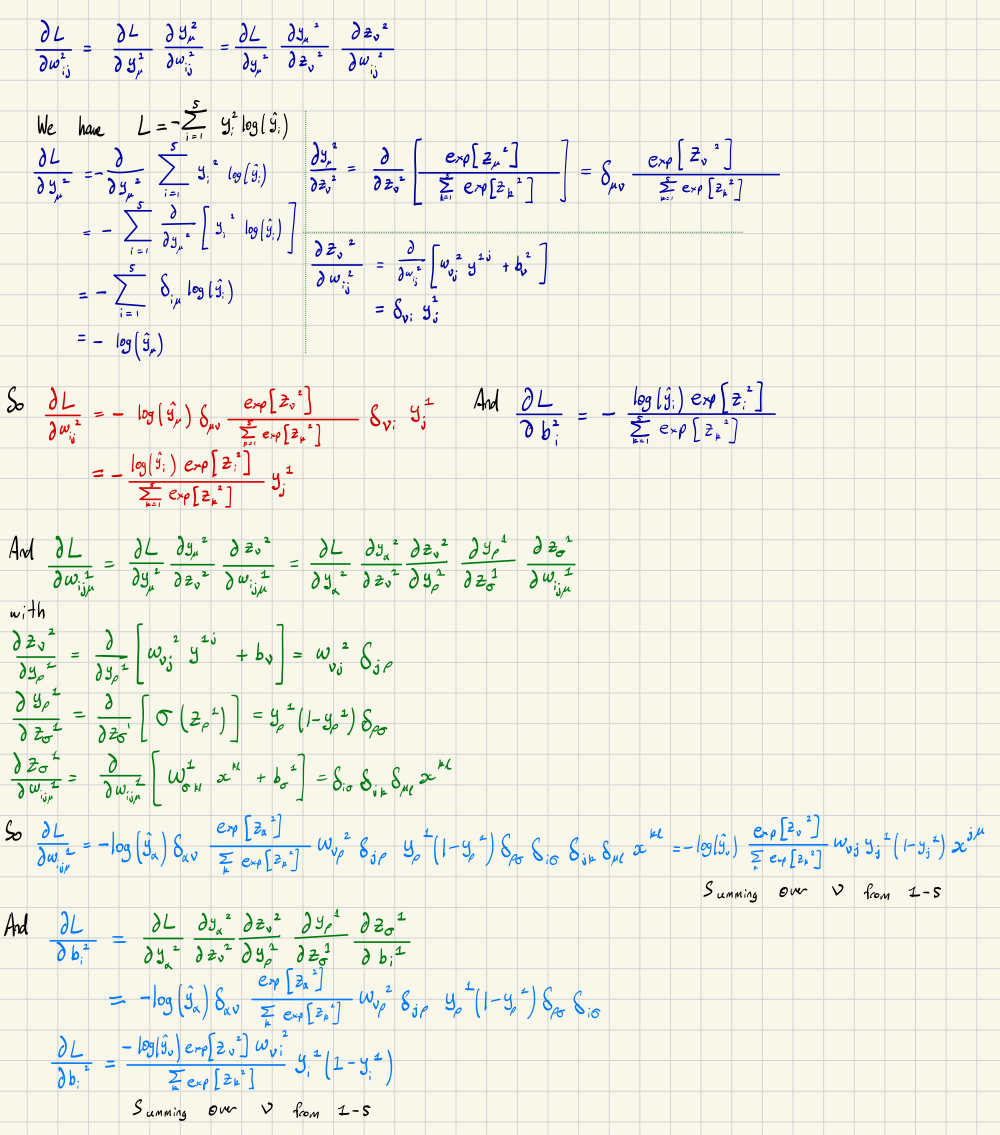

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Text(0, 0.5, 'Probability')

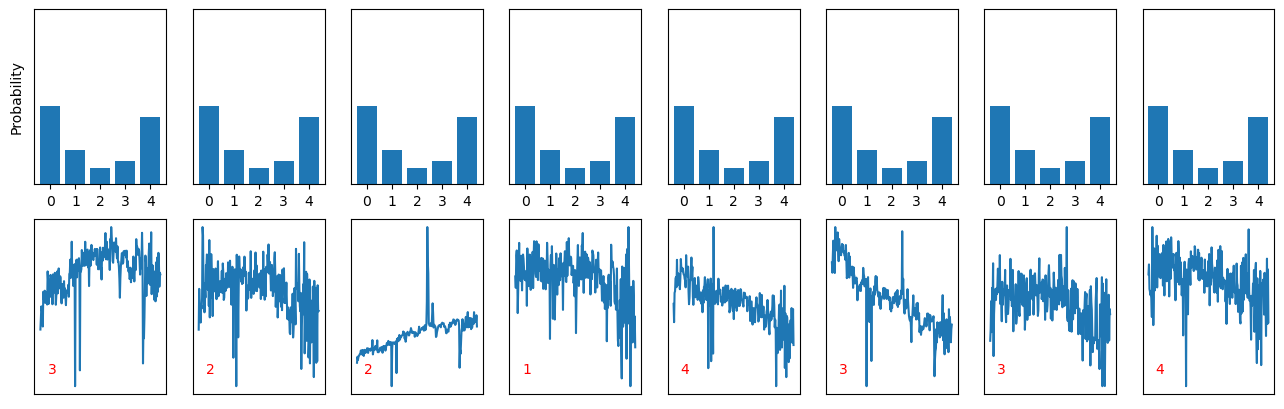

In [17]:
num_col = 8
fig, axes = plt.subplots(2, num_col, figsize=(num_col*2,5))
output = model.predict(x_test[:num_col])

for i in range(num_col):
    ax = axes[1,i]
    ax.plot(x[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.1,0.1, labels_test[i], va='bottom', ha='left', transform=ax.transAxes, color='r')
    axp = axes[0,i]
    axp.bar(np.arange(5), output[i])
    axp.set_xticks(np.arange(5))
    axp.set_yticks([])
    axp.set_ylim(0,0.8)
axes[0,0].set_ylabel('Probability')

In [18]:
# register the model
l_rate = 0.1

model.compile(
    optimizer=optimizers.Adam(learning_rate=l_rate),    # Optimizer
    loss='categorical_crossentropy',                    # Loss function
)

Use the callbacks feature of tensorFlow by defining custom classes that perform actions when epochs finish training. I store these outputs in a simple list before working with them later

In [19]:
weightList = []
gradientList = []
outputList = []

class WeightsAndLossLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        loss = logs.get('loss')
        weightList.append(weights)


class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, data_batch):
        super().__init__()
        self.data_batch = data_batch

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.data_batch

        with tf.GradientTape() as tape:
            y_pred = self.model(x, training=True)
            loss = self.model.compiled_loss(y, y_pred)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        gradientList.append(gradients)

class OutputLogger(tf.keras.callbacks.Callback):
    def __init__(self, sample_input):
        self.sample_input = sample_input

    def on_epoch_end(self, epoch, logs=None):
        output = self.model(self.sample_input, training=False)
        outputList.append(output)


In [20]:
# Train the model
n_epochs = 25

sample = [x_train, y_train]

history = model.fit(
    x_train, y_train,
    epochs=n_epochs,
    validation_split=0.2,
    callbacks = [
        WeightsAndLossLogger(),
        GradientLogger(sample),
        OutputLogger(sample)
    ]
)

Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6308 - val_loss: 0.7601
Epoch 2/25
42/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7110 

c:\Users\taase\anaconda3\lib\site-packages\keras\src\backend\tensorflow\trainer.py:671: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
c:\Users\taase\anaconda3\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(3451, 250))', 'Tensor(shape=(3451, 5))']
  warnings.warn(msg)


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6851 - val_loss: 0.5287
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5518 - val_loss: 0.4631
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5686 - val_loss: 0.3921
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4347 - val_loss: 0.3538
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4309 - val_loss: 0.3246
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3824 - val_loss: 0.3292
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3504 - val_loss: 0.3639
Epoch 9/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3568 - val_loss: 0.2597
Epoch 10/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3261 - val_loss: 0.2393
Epoch 11/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3199 - val_loss: 0.2192
Epoch 12/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2914 - val_loss: 0.2414
Epoch 13/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2946 - val_loss: 0.2850

Get the weights from the weightList list. This will give us $w^1_{ij}$, $b^1_i$, $w^2_{ij}$, and $b^2_i$ over the first ten epochs.

In [21]:
#weightList[epoch][level (0,1,2,3) ]
b_2_i = np.array([ weightList[i][3] for i in range(10) ])
w_2_ij = np.array([ weightList[i][2] for i in range(10) ])
b_1_i = np.array([ weightList[i][1] for i in range(10) ])
w_1_ij = np.array([ weightList[i][0] for i in range(10) ])

Do the same for the gradients, which are $\frac{dL}{d?}$ where $?$ is one of the four weights

In [22]:
# gradientList[epoch][0123]
dL_dw_1 = np.array([gradientList[i][0] for i in range(10)])
dL_db_1 = np.array([gradientList[i][1] for i in range(10)])
dL_dw_2 = np.array([gradientList[i][2] for i in range(10)])
dL_db_2 = np.array([gradientList[i][3] for i in range(10)])

Store the outputs as a tensorFlow tensor and back to an array to store it as a file. The outputs are of shape [10, 3451, 5] so that: for every epoch, eavh of the 3451 training spectra are assigned probabilities for the 5 categories.

In [23]:
outputs = tf.convert_to_tensor(outputList)
outputs_arr = np.array(outputs[:10,:,:])

Save using numpy arrays since they can easily handle higher dimensional data as we're working with.

In [24]:
np.savez("data\\lossrate_01\\gradients.npz", dLdw1=dL_dw_1, dLdb1=dL_db_1, dLdw2=dL_dw_2, dLdb2=dL_db_2)
np.savez("data\\lossrate_01\\weights.npz", w1 = w_1_ij, b1 = b_1_i, w2 = w_2_ij, b2 = b_2_i)
np.save("data\\lossrate_01\\outputs.npy", arr=outputs_arr)
np.savez("data\\lossrate_01\\losses.npz", loss=history.history["loss"][:10], val_loss=history.history["val_loss"][:10])

Now we'll plot the losses over time for a learning rate of 0.1

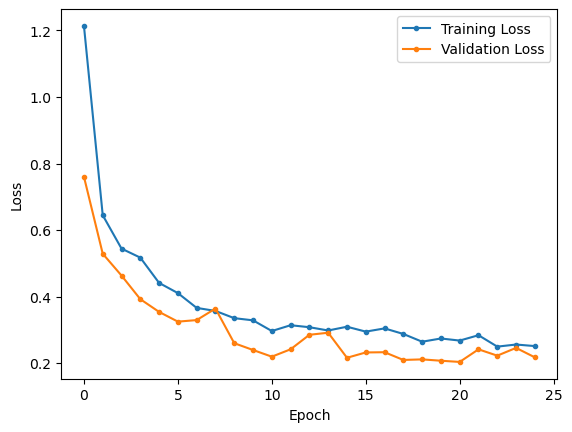

In [25]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss', marker=".")
ax.plot(history.history['val_loss'], label='Validation Loss', marker=".")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

The training set decreases approximately monotonically over the first 10 epochs. Now we want to sese its identification power.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Text(0, 0.5, 'Probability')

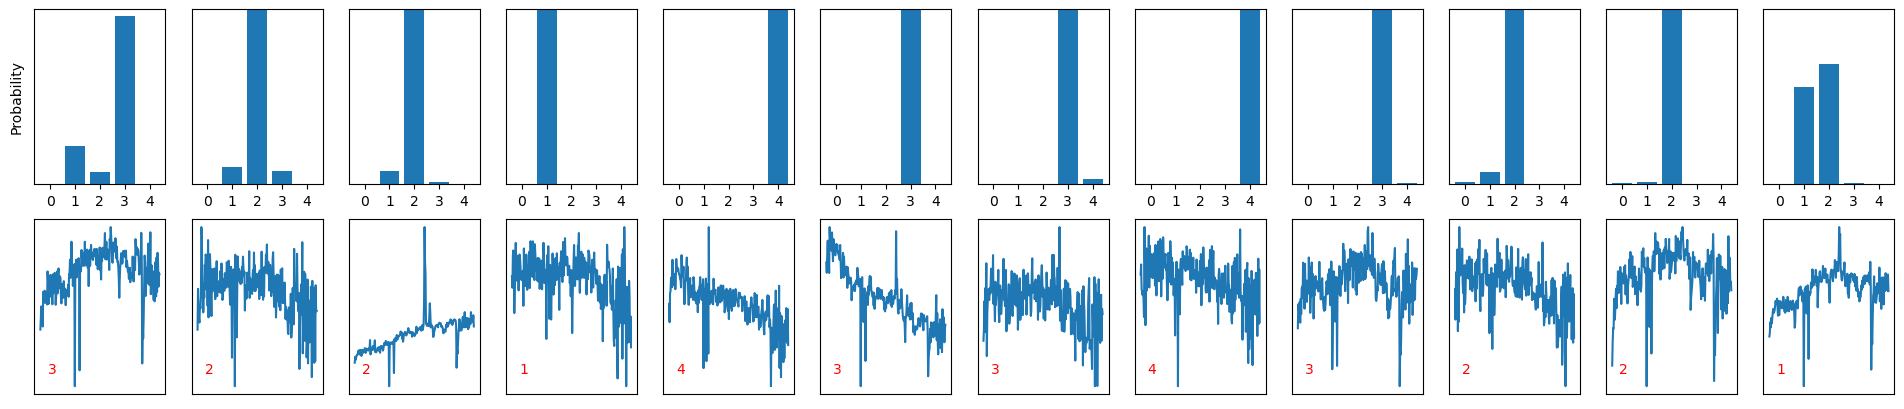

In [26]:
num_col = 12
fig, axes = plt.subplots(2, num_col, figsize=(num_col*2,5))
output = model.predict(x_test[:num_col])

for i in range(num_col):
    ax = axes[1,i]
    # ax.imshow(images_test[i], cmap='gray')
    ax.plot(x[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.1,0.1, labels_test[i], va='bottom', ha='left', transform=ax.transAxes, color='r')
    axp = axes[0,i]
    axp.bar(np.arange(5), output[i])
    axp.set_xticks(np.arange(5))
    axp.set_yticks([])
    axp.set_ylim(0,0.8)
axes[0,0].set_ylabel('Probability')

At first glance, the neural network has done exceptionally well for the first 12 galaxies in the test set!

I now repeat the steps for a larger learning rate (0.5).

Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1042 - val_loss: 1.5491
Epoch 2/25
65/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5482

c:\Users\taase\anaconda3\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_3
Received: inputs=['Tensor(shape=(3451, 250))', 'Tensor(shape=(3451, 5))']
  warnings.warn(msg)


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5093 - val_loss: 0.7730
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6926 - val_loss: 0.6389
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5866 - val_loss: 0.4701
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5021 - val_loss: 0.4179
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4348 - val_loss: 0.5017
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4645 - val_loss: 0.3510
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4101 - val_loss: 0.3213
Epoch 9/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3795 - val_loss: 0.2879
Epoch 10/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3111 - val_loss: 0.2660
Epoch 11/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3283 - val_loss: 0.3403
Epoch 12/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4152 - val_loss: 0.4899
Epoch 13/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3378 - val_loss: 0.3205

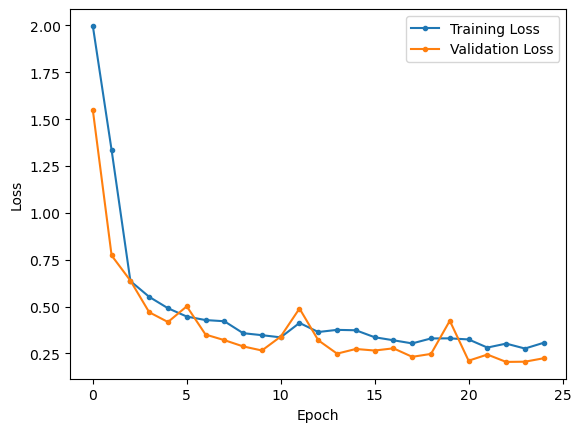

In [27]:
model = models.Sequential([
    layers.Input(shape=(250,)),                    # Input layer
    layers.Dense(64, activation='sigmoid'),        # Hidden layer
    layers.Dense(5, activation='softmax')          # Output layer
])

l_rate = 0.5

model.compile(
    optimizer=optimizers.Adam(learning_rate=l_rate),    # Optimizer
    loss='categorical_crossentropy',                    # Loss function
)

weightList = []
gradientList = []
outputList = []

class WeightsAndLossLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        loss = logs.get('loss')
        weightList.append(weights)


class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, data_batch):
        super().__init__()
        self.data_batch = data_batch

    def on_epoch_end(self, epoch, logs=None):
        x, y = self.data_batch

        with tf.GradientTape() as tape:
            y_pred = self.model(x, training=True)
            loss = self.model.compiled_loss(y, y_pred)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        gradientList.append(gradients)

class OutputLogger(tf.keras.callbacks.Callback):
    def __init__(self, sample_input):
        self.sample_input = sample_input

    def on_epoch_end(self, epoch, logs=None):
        output = self.model(self.sample_input, training=False)
        outputList.append(output)

# Train the model
n_epochs = 25

sample = [x_train, y_train]

history = model.fit(
    x_train, y_train,
    epochs=n_epochs,
    validation_split=0.2,
    callbacks = [
        WeightsAndLossLogger(),
        GradientLogger(sample),
        OutputLogger(sample)
    ]
)

fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss', marker=".")
ax.plot(history.history['val_loss'], label='Validation Loss', marker=".")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.show()

In [28]:
#weightList[epoch][level (0,1,2,3) ]
b_2_i = np.array([ weightList[i][3] for i in range(10) ])
w_2_ij = np.array([ weightList[i][2] for i in range(10) ])
b_1_i = np.array([ weightList[i][1] for i in range(10) ])
w_1_ij = np.array([ weightList[i][0] for i in range(10) ])

# gradientList[epoch][0123]
dL_dw_1 = np.array([gradientList[i][0] for i in range(10)])
dL_db_1 = np.array([gradientList[i][1] for i in range(10)])
dL_dw_2 = np.array([gradientList[i][2] for i in range(10)])
dL_db_2 = np.array([gradientList[i][3] for i in range(10)])

outputs = tf.convert_to_tensor(outputList)
outputs_arr = np.array(outputs[:10,:,:])

np.savez("data\\lossrate_05\\gradients.npz", dLdw1=dL_dw_1, dLdb1=dL_db_1, dLdw2=dL_dw_2, dLdb2=dL_db_2)
np.savez("data\\lossrate_05\\weights.npz", w1 = w_1_ij, b1 = b_1_i, w2 = w_2_ij, b2 = b_2_i)
np.save("data\\lossrate_05\\outputs.npy", arr=outputs_arr)
np.savez("data\\lossrate_05\\losses.npz", loss=history.history["loss"][:10], val_loss=history.history["val_loss"][:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Text(0, 0.5, 'Probability')

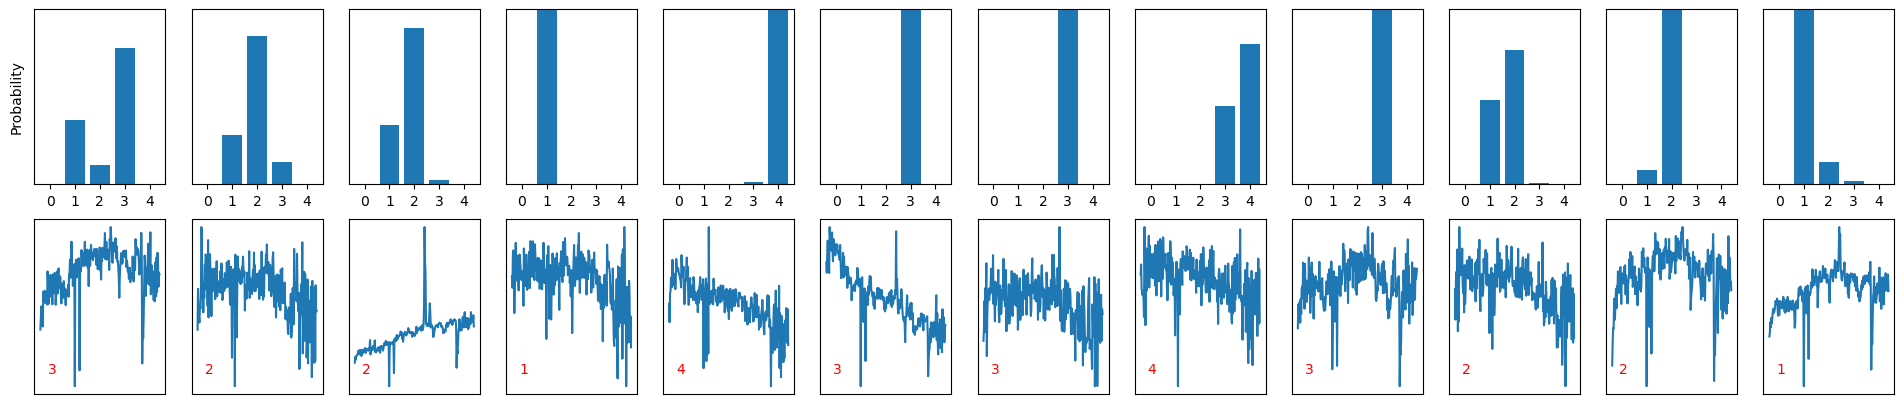

In [29]:
num_col = 12
fig, axes = plt.subplots(2, num_col, figsize=(num_col*2,5))
output = model.predict(x_test[:num_col])

for i in range(num_col):
    ax = axes[1,i]
    # ax.imshow(images_test[i], cmap='gray')
    ax.plot(x[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.1,0.1, labels_test[i], va='bottom', ha='left', transform=ax.transAxes, color='r')
    axp = axes[0,i]
    axp.bar(np.arange(5), output[i])
    axp.set_xticks(np.arange(5))
    axp.set_yticks([])
    axp.set_ylim(0,0.8)
axes[0,0].set_ylabel('Probability')

A higher loss rate still seems to work mostly well and the loss converges.